In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [7]:
torch.cuda.empty_cache()

In [11]:
batch_size = 64
num_epochs = 50
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='/root/data/imagenette_wb/train/', transform=transform)
test_dataset = datasets.ImageFolder(root='/root/data/imagenette_wb/val/', transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
wb_dataset = datasets.ImageFolder(root='/root/data/syn_data/imagenette/23', transform=transform)
wb_loader = DataLoader(dataset=wb_dataset, batch_size=batch_size, shuffle=False)

In [10]:
model = models.resnet101(pretrained=False)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/50], Loss: 1.6671
Epoch [2/50], Loss: 1.2827
Epoch [3/50], Loss: 1.5515
Epoch [4/50], Loss: 1.0690
Epoch [5/50], Loss: 0.8379
Epoch [6/50], Loss: 0.7422
Epoch [7/50], Loss: 0.7068
Epoch [8/50], Loss: 0.8724
Epoch [9/50], Loss: 0.3943
Epoch [10/50], Loss: 0.4935
Epoch [11/50], Loss: 0.6503
Epoch [12/50], Loss: 0.3990
Epoch [13/50], Loss: 0.5722
Epoch [14/50], Loss: 0.5985
Epoch [15/50], Loss: 0.3313
Epoch [16/50], Loss: 0.3772
Epoch [17/50], Loss: 0.2129
Epoch [18/50], Loss: 0.5022
Epoch [19/50], Loss: 0.1824
Epoch [20/50], Loss: 0.2824
Epoch [21/50], Loss: 0.0495
Epoch [22/50], Loss: 0.0811
Epoch [23/50], Loss: 0.2023
Epoch [24/50], Loss: 0.1036
Epoch [25/50], Loss: 0.0735
Epoch [26/50], Loss: 0.0225
Epoch [27/50], Loss: 0.2328
Epoch [28/50], Loss: 0.0506
Epoch [29/50], Loss: 0.0962
Epoch [30/50], Loss: 0.1623
Epoch [31/50], Loss: 0.1085
Epoch [32/50], Loss: 0.0347
Epoch [33/50], Loss: 0.1428
Epoch [34/50], Loss: 0.0349
Epoch [35/50], Loss: 0.3713
Epoch [36/50], Loss: 0.0437
E

In [20]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print('Accuracy of the model on the test images: {}%'.format(accuracy))

Accuracy of the model on the test images: 79.38853503184713%


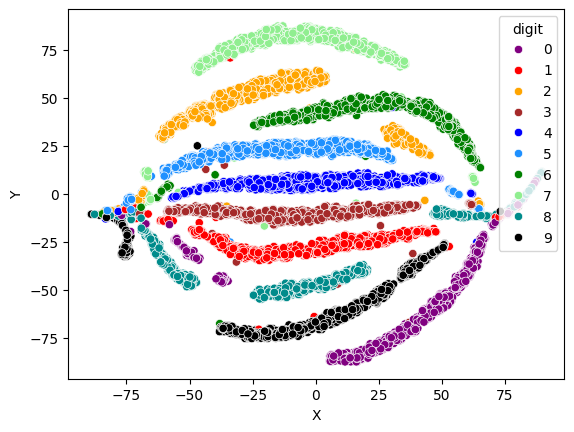

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns

model = model.eval()

features_list = []
labels_list = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        outputs = model(images)
        
        features_list.append(outputs.cpu().detach().numpy())
        labels_list.append(labels.numpy())

features = np.concatenate(features_list)
labels = np.concatenate(labels_list)

tsne = TSNE(n_components=2, random_state=0, perplexity=30)
tsne_obj= tsne.fit_transform(features)

tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'digit':labels})

sns.scatterplot(x="X", y="Y",
              hue="digit",
              palette=['purple','red','orange','brown','blue',
                       'dodgerblue','green','lightgreen','darkcyan', 'black'],
              legend='full',
              data=tsne_df)
plt.show()

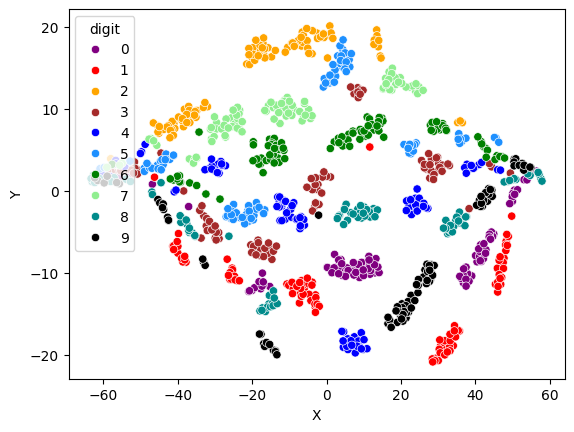

In [18]:
model = model.eval()
distilled_features_list = []
distilled_labels_list = []

with torch.no_grad():
    for images, labels in wb_loader:
        images = images.to(device)
        outputs = model(images)
        
        distilled_features_list.append(outputs.cpu().detach().numpy())
        distilled_labels_list.append(labels.numpy())
        
distilled_features = np.concatenate(distilled_features_list)
distilled_labels = np.concatenate(distilled_labels_list)

tsne = TSNE(n_components=2, random_state=0)
distilled_tsne_obj= tsne.fit_transform(distilled_features)

tsne_df = pd.DataFrame({'X':distilled_tsne_obj[:,0],
                        'Y':distilled_tsne_obj[:,1],
                        'digit':distilled_labels})

sns.scatterplot(x="X", y="Y",
              hue="digit",
              palette=['purple','red','orange','brown','blue',
                       'dodgerblue','green','lightgreen','darkcyan', 'black'],
              legend='full',
              data=tsne_df)
plt.show()